# Continuous Actor-Critic with Trajectory Optimization" (CACTO)
Basic implementation of the algorithm CACTO for a single integrator dynamics with non-convex cost function.
This implementation is based on JAX, and it is not completely equivalent to the original CACTO algorithm, but it is somehow simplified for sake of simplicity. Nonetheless, it maintains the core principles of the algorithm.

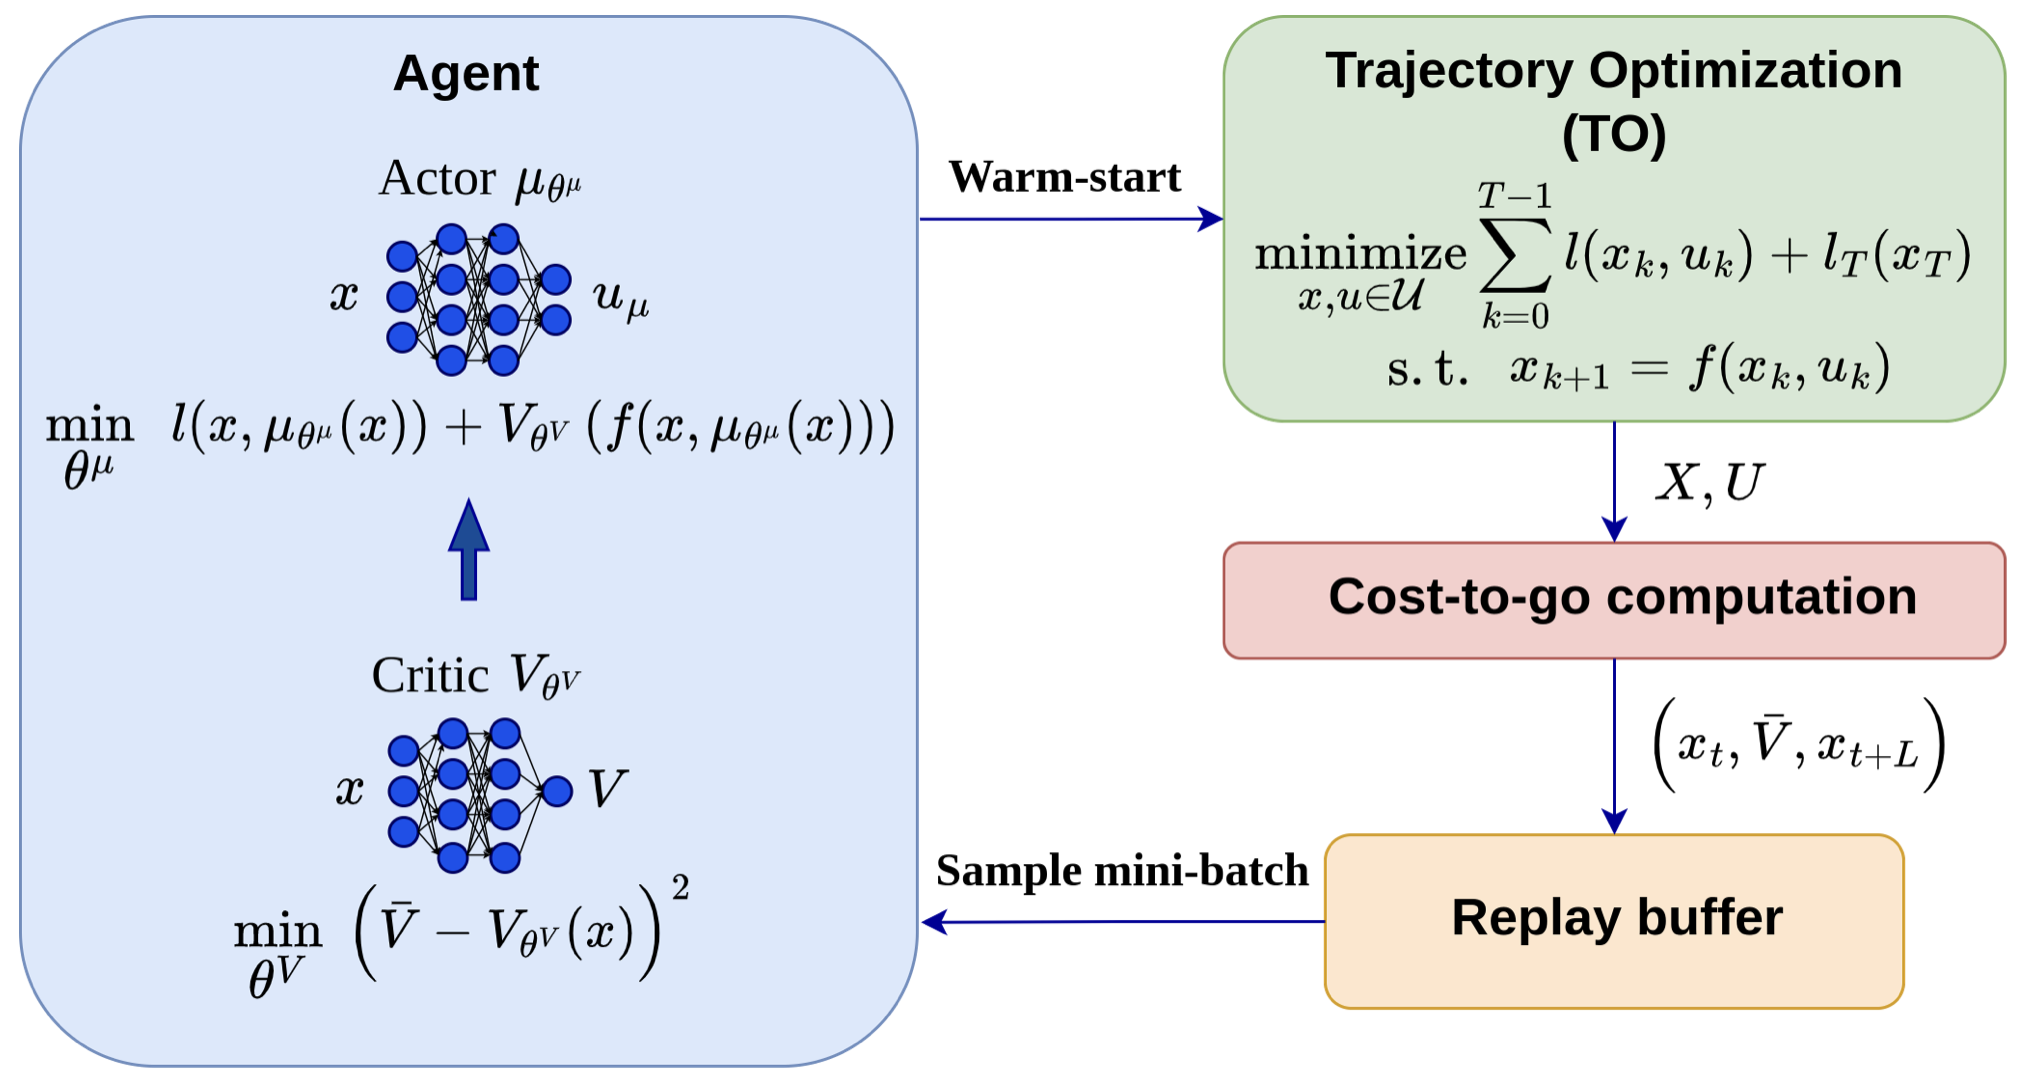

## Summary of the algorithm
CACTO boils down to repeating in a loop the following steps:
* Solve a batch of Trajectory Optimization (TO) problems with different initial states and different horizon lengths.
* For each state of the computed trajectories, compute the associated cost-to-go $\bar{V}$ and store it in a replay buffer. Note that since this implementation of CACTO uses Monte Carlo (instead of Temporal Difference) we do not need to store the future state in the replay buffer.
* Sample randomly from the replay buffer and use the data to train the critic network so that it matches the stored cost-to-go.
* Sample randomly from the replay buffer and use the data to train the actor network by minimizing the Q function computed by using the critic network, the cost function and the system dynamics.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax
import flax.linen as nn
from typing import Sequence
import timeit # start_time = timeit.default_timer()
import casadi

# set default values for getting nice plots
mpl.rcParams["lines.linewidth"] = 4
mpl.rcParams["font.size"] = 16
mpl.rcParams["legend.fontsize"] = 16
mpl.rcParams["axes.labelsize"] = 16
mpl.rcParams["axes.grid"] = True

Define the cost and the dynamics. To get fast computation times we use an extremely simple dynamical system, that is a 1D single integrator:

$ x_{i+1} = x_i + \Delta t \, u_i$

The cost is instead defined as a 6-th order polynomial on the state (which presents three local minima) plus a quadratic penalty on the control with weight $w_u \ge 0$:

$ l(x,u) = (x-1.9)(x-1.0)(x-0.6)(x+0.5)(x+1.2)(x+2.1) + w_u \, u^2$

The terminal cost is assumed to be equal to the running cost computed with zero control inputs.

Define also the augmented versions of these functions that use an augmented version of the state including time as last component. This is useful because the actor and critic networks depend on both state and time.

In [ ]:
dt = 0.1        # time step
w_u = 0.1       # weight of the penalty on the control inputs u

def cost(x, u):
    x = x[0]
    c = w_u*u*u + (x-1.9)*(x-1.0)*(x-0.6)*(x+0.5)*(x+1.2)*(x+2.1)
    return c[0]
    
def cost_aug(x_aug, u):
    return cost(x_aug[:-1], u)

def dynamic(x, u):
    x_next = x + dt*u
    return x_next

def dynamic_aug(x_aug, u):
    x_next = dynamic(x_aug[:-1], u)
    x_aug_next = jnp.concatenate([x_next, jnp.array([x_aug[-1]+1])])
    return x_aug_next

Create a grid of states used for plots.

In [ ]:
x_min, x_max = -2.2, 2.1       # range of x to explore and plot
n_x, n_u = 1, 1                # size of state x and control u
N_grid = 100                   # number of states used for plots
X_grid = jnp.linspace(x_min, x_max, N_grid).reshape((N_grid,n_x))

Plot the cost function, which has 3 local minima.

In [ ]:
running_cost = [cost(np.array([x]), 0) for x in X_grid]
plt.plot(X_grid, running_cost)
plt.xlabel("State")
plt.title("Running cost")
plt.show()

Define all the parameters of the problem and the algorithm.

In [ ]:
RANDOM_SEED = 0                # seed of the randon number generator

# PARAMETERS OF THE PROBLEM
N = 10                   # horizon size

# PARAMETERS OF THE ALGORITHM (CACTO)
critic_layers = [8, 8, 8]      # number of neurons of the NN layers of the critic
actor_layers = [8, 8, 8]       # number of neurons of the NN layers of the actor
N_OCP = 100                    # number of Optimal Control Problems (OCP) solved at each iteration
learning_rate_critic = 0.005   # learning rate used for updating the weights of the critic
learning_rate_actor = 0.005    # learning rate used for updating the weights of the actor
minibatch_size = 128           # size of the minibatch
critic_updates = 300           # number of updates of the critic for every training
actor_updates = 300            # number of updates of the actor for every training
max_actor_iter = 20            # number of trainings of the actor for every CACTO iteration
max_critic_iter = 20          # number of trainings of the critic for every CACTO iteration

Define a class for solving the optimal control problem with the optimal control library Casadi.

In [ ]:
'''
A class to solve an Optimal Control Problem (OCP) for a single integrator.
'''
class OcpSingleIntegrator:

    def __init__(self):
        pass

    def solve(self, x_init, N, X_guess=None, U_guess=None):
        self.opti = casadi.Opti()
        
        # create the state and control variables
        self.x = self.opti.variable(N+1)
        self.u = self.opti.variable(N)
        x = self.x
        u = self.u

        # warm-start the solver with the provided initial guess (if any)
        if(X_guess is not None):
            for i in range(N+1):
                self.opti.set_initial(x[i], X_guess[i,:])
        else:
            # otherwise initialize the state trajectory with the initial state
            for i in range(N+1):
                self.opti.set_initial(x[i], x_init)
        if(U_guess is not None):
            for i in range(N):
                self.opti.set_initial(u[i], U_guess[i,:])

        # define the cost function
        self.cost = 0
        self.running_costs = [None,]*(N+1)
        for i in range(N+1):
            if(i<N):
                self.running_costs[i] = cost(x[i], u[i])
            else:
                # the final cost is the same as the running cost but with zero control inputs
                self.running_costs[i] = cost(x[i], 0.0)
            self.cost += self.running_costs[i]
        self.opti.minimize(self.cost)

        # Define the dynamics constraints
        for i in range(N):
            self.opti.subject_to( x[i+1]== dynamic(x[i], u[i]) )

        # Set the initial state
        self.opti.subject_to(x[0]==x_init)

        # Solve the problem with IpOpt
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
        self.opti.solver("ipopt", opts)

        return self.opti.solve()

Create an OCP solver and start evaluating it w/o initial guess. We can see how the trajectories converge to the three local minima, depending on the initial state.

In [ ]:
ocp = OcpSingleIntegrator()

CACTO_ITERS = 2    # number of iterations of the algorithm
V = np.empty((N_grid,CACTO_ITERS+1)) # Value function at each state (in the grid) for each CACTO iteration
plt.figure()
for (i, x_init) in enumerate(X_grid):
    sol = ocp.solve(x_init, N)   # solve the OCP with initial state x_init and horizon N
    V[i,0] = sol.value(ocp.cost) # store total cost in Value function
    x_traj = [sol.value(ocp.x[j]) for j in range(N)]
    plt.plot(x_traj, alpha=0.7, linewidth=1)
plt.xlabel("Time")
plt.ylabel("State")
plt.show()
print("Average optimal cost-to-go:\n", jnp.mean(V[:,0]))

plt.figure()
plt.plot(X_grid, V[:,0]/(N+1), alpha=0.5, label="Optimal cost-to-go (avg)")
plt.plot(X_grid, running_cost, alpha=0.5, label="Running cost")
plt.xlabel("Initial state")
plt.legend()
plt.show()

Define a class representing the replay buffer. Data is stored using Python lists, but when retrieved with the "get" methods it is converted to Jax arrays, so that it can be directly used to train/evaluate the neural networks.

In [ ]:
class ReplayBuffer:
    def __init__(self, name):
        self.name = name
        self.X = []
        self.Out = []

    def append(self, x, out):
        self.X.append(x)
        self.Out.append(out)

    def getX(self):
        return jnp.array(self.X)
    
    def getOut(self):
        return jnp.array(self.Out).reshape((len(self.Out),1))
    
    def clean(self):
        self.X = []
        self.Out = []

Define a class representing a standard Multi-Layer Perceptron neural network based on Flax. This neural network will be used to represent the critic and the actor. We use the ELU activation function, which is a smooth version of the ReLU (Rectified Linear Unit) function.

In [ ]:
# A multi-layer perceptron using ELU activation functions
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.elu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x


# Function to update the weights of the network
@jax.jit
def update_params(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params

Define a class that contains a neural network and the standard machinery for training the network to fit a given target using a Mean-Squared Error loss. 

$ \text{loss}(\theta) = \sum_{i=0}^{k-1} \frac{1}{2} || V_\theta(x_i) - \bar{V}_i ||^2$

This class will be used for the critic, which needs to be trained in a standard supervised-learning fashion.

In [ ]:
class NeuralNetwork:
    def __init__(self, name, in_dim, out_dim, layer_sizes, learning_rate=0.1, random_seed=0):
        # Set problem dimensions.
        self.name = name
        self.random_seed = random_seed
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.learning_rate = learning_rate

        self.model = MLP(layer_sizes + [out_dim])
        k1, k2 = random.split(random.key(random_seed))
        x = random.normal(k1, (in_dim,)) # Dummy input data
        self.params = self.model.init(k2, x) # Initialization call
        jax.tree_util.tree_map(lambda x: x.shape, self.params) # Checking output shapes

        # Mean-Squared Error loss function
        @jax.jit
        def mse(params, x_batched, y_batched):
            # Define the squared loss for a single pair (x,y)
            def squared_error(x, y):
                pred = self.model.apply(params, x)
                return jnp.inner(y-pred, y-pred) / 2.0
            # Vectorize the previous to compute the average of the loss on all samples.
            return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)
        
        # function computing both the loss and its gradient
        self.loss_grad_fn = jax.value_and_grad(mse)
        # function computing the loss
        self.loss = mse


    def __call__(self, x):
       return self.model.apply(self.params, x)


    def train(self, in_samples, out_samples, n_iter=1, minibatch_size=32, learning_rate=None):
        ''' Perform n_iter training iterations with the specified minibatch size using the 
            provided data.
        '''
        if(learning_rate is None):
           learning_rate = self.learning_rate
        
        N = in_samples.shape[0]
        assert(out_samples.shape[0]==N)
        for i in range(n_iter): 
            # Perform one gradient update.    
            ind = np.random.randint(N, size=minibatch_size)
            loss_val, grads = self.loss_grad_fn(self.params, in_samples[ind,:], out_samples[ind,:])
            self.params = update_params(self.params, learning_rate, grads)
        return self.loss(self.params, in_samples, out_samples)

Define a class containing the actor network and the code for training it. Since the actor is trained by minimizing the Q function, we need to pass it the cost $l(x,u)$, the Value network model $V(\cdot)$ and the dynamic model $f(x,u)$, because the Q function is computed as:

$Q(x,u) = l(x,u) + V(f(x,u))$

In [ ]:
class ActorNetwork:
    def __init__(self, name, in_dim, out_dim, layer_sizes, cost, V_model, dynamic, learning_rate=0.1, random_seed=0):
        # Set problem dimensions.
        self.name = name
        self.random_seed = random_seed
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.learning_rate = learning_rate

        self.model = MLP(layer_sizes + [out_dim])
        self.V_model = V_model
        self.dynamic = dynamic
        self.cost = cost

        k1, k2 = random.split(random.key(random_seed))
        x = random.normal(k1, (in_dim,)) # Dummy input data
        self.params = self.model.init(k2, x) # Initialization call
        jax.tree_util.tree_map(lambda x: x.shape, self.params) # Checking output shapes


    def __call__(self, x):
       return self.model.apply(self.params, x)
    
    
    def train(self, in_samples, n_iter=1, minibatch_size=32, learning_rate=None):
        if(learning_rate is None):
           learning_rate = self.learning_rate

        # the loss function is the Q function, which is: 
        # Q(x,u) = cost(x,u) + V(f(x,u))
        def Q_batch(params, x_batched):           
            def Q_single(x):
                u = self.model.apply(params, x)
                return self.cost(x, u) + self.V_model(self.dynamic(x,u))[0]
            # use vmap to vectorize this computation over the batch
            return jnp.mean(jax.vmap(Q_single)(x_batched), axis=0)

        # function computing the loss and its gradient
        self.loss_grad_fn = jax.jit(jax.value_and_grad(Q_batch))
        # function computing the loss
        self.loss = Q_batch

        N = in_samples.shape[0]
        for i in range(n_iter):
            # Perform one gradient update.            
            ind = np.random.randint(N, size=minibatch_size)
            loss_val, grads = self.loss_grad_fn(self.params, in_samples[ind,:])
            self.params = update_params(self.params, learning_rate, grads)
        return self.loss(self.params, in_samples)

Create main components of CACTO:
* Critic network
* Actor network
* Replay buffer

Note that the input size of the actor and critic network is equal to the size of the state plus one, to account for the time. We create also a second replay buffer to store the optimal control inputs just for plots.


In [ ]:
critic = NeuralNetwork("Critic", n_x+1, 1, critic_layers, learning_rate_critic, RANDOM_SEED)
actor  = ActorNetwork("Policy", n_x+1, n_u, actor_layers, cost_aug, critic, dynamic_aug, 
                    learning_rate_actor, RANDOM_SEED)
replay_buffer = ReplayBuffer("V")
control_buffer = ReplayBuffer("U")

# Start CACTO's main loop
Solve a batch of TO problems starting from random initial states and initial times. However, rather than sampling the horizon length in $[1, N]$ (as in the original CACTO algorithm) we fix it to $N-1$. The reason why we do it is that in this notebook we are interested in getting a good policy for $t=0$, therefore we should get a good critic for $t=1$, so we mainly care about exploring the state space for $t=1$, which is the initial time when the horizon is $N-1$. However we should acknowledge that fixing the horizon length to N-1 is problematic, as we may not explore the whole state space for time steps greater than 1. However, for the purpose of this notebook, this is fine.

In [ ]:
def solve_TO_problems(use_actor_to_warm_start=False):
    print("Start solving %d TO problems"%N_OCP)
    replay_buffer.clean() # empty replay buffer for simplicity even though CACTO does not do that
    control_buffer.clean()
    start_time = timeit.default_timer()
    # sample initial states and initial times
    X_samples = np.random.uniform(x_min, x_max, size=(N_OCP, n_x))
    # the initial time is sampled by sampling a horizon length
    # Rather than sampling in [1, N] we sample in [N-1, N] to ensure a more uniform coverage 
    # of the time domain in the replay buffer data
    N_samples = np.random.randint(N-1, N, size=N_OCP) # sample in [N-1, N]

    # if this is not the first iteration, use the actor to compute an initial guess for each initial state-time
    # Otherwise the initial guess is set to None
    X_guess, U_guess = N_OCP*[None,], N_OCP*[None,]
    if(use_actor_to_warm_start): # compute initial guess
        for i in range(N_OCP):
            X_guess[i], U_guess[i], dummy = compute_initial_guess(X_samples[i,:], N-N_samples[i], N_samples[i], n_x, n_u, actor)

    # solve an OCP for every sampled initial state-time
    for i in range(N_OCP):
        sol = ocp.solve(X_samples[i,:], N_samples[i], X_guess[i], U_guess[i])
        # recover the whole optimal trajectory
        J = 0
        for j in range(N_samples[i], -1, -1):
            # create an augmented state adding the time as last component
            x_aug = jnp.array([sol.value(ocp.x[j]), N-N_samples[i]+j])
            # compute the optimal cost from the augmented state x_aug
            J += sol.value(ocp.running_costs[j])
            # add the element to the replay buffer
            replay_buffer.append(x_aug, J)

            # save optimal control inputs for plots
            if(j<N_samples[i]):
                control_buffer.append(x_aug, sol.value(ocp.u[j]))

    print(f"Finished solving TO problems, which took {timeit.default_timer() - start_time:.3f} s")
    
solve_TO_problems()

## Train the critic network

Define a function to plot the critic network for a certain time, together with the data computed with TO.

In [ ]:
def plot_critic(crit, t=0, show=True):
    X = replay_buffer.getX()
    ind = jnp.where(X[:,1] == t)[0]
    X_aug = jnp.vstack([X_grid[:,0], t*np.ones(X_grid.shape[0])]).T

    plt.figure()
    plt.plot(X_grid, crit(X_aug)/(N+1-t), 'r-', label=crit.name)
    plt.plot(X[ind,0].T, replay_buffer.getOut()[ind]/(N+1-t), 'x ', label='Value TO')
    plt.plot(X_grid, running_cost, alpha=0.5, label="Cost")
    plt.xlabel("State x")
    plt.title("Critic for t="+str(t))
    plt.legend()
    plt.show()

Start the training using the data from the buffer.

In [ ]:
def train_critic():
    print("Start training critic")
    X_aug, V_buffer = replay_buffer.getX(), replay_buffer.getOut() 
    for i in range(max_critic_iter):
        critic_loss = critic.train(X_aug, V_buffer, critic_updates, minibatch_size=minibatch_size)
        print("Iter", i, "\tCritic loss", critic_loss)
        if((i+1)%5==0): # every 5 iters plot the critic function for time t=1
            plot_critic(critic, 1) 
    print("Critic training has finished")
    for t in range(1, N, N):
        plot_critic(critic, t, show=False)
train_critic()

## Train the actor network

Define a function to plot the actor network for a given time.

In [ ]:
def plot_actor(t=0, show=True, plot_u_ocp=True, plot_running_cost=True):
    X = control_buffer.getX()
    ind = jnp.where(X[:,1] == t)
    X_aug = jnp.vstack([X_grid[:,0], t*np.ones(X_grid.shape[0])]).T
    plt.figure()
    if(plot_u_ocp): plt.plot(X[ind,0].T, control_buffer.getOut()[ind], 'x ', label='u TO')
    if(plot_running_cost): plt.plot(X_grid, running_cost, label="cost", alpha=0.5)
    plt.plot(X_grid, actor(X_aug), 'r-', label='Actor')
    plt.title("Actor for t="+str(t))
    plt.xlabel("State x")
    plt.legend()
    if(show):
        plt.show()

Start training the actor network using the data from the buffer.

In [ ]:
def train_actor():
    # store the actor's output before training for plots
    X_grid_aug = jnp.vstack([X_grid[:,0], 0*np.ones(X_grid.shape[0])]).T
    actor_pre_train = actor(X_grid_aug)
    X_aug = replay_buffer.getX()
    
    # create a function to evaluate quickly the gradient of the Q function (for plots)
    @jax.jit
    def Q_func(u, x_aug):
        return cost_aug(x_aug,u) + critic(dynamic_aug(x_aug,u))[0]
    grad_Q = jax.jit(jax.grad(Q_func))
    
    print("Start training the actor")
    for i in range(max_actor_iter):
        actor_loss = actor.train(X_aug, actor_updates, minibatch_size=minibatch_size) 
        # compute the norm of the gradient of the Q function wrt u just for printing it because
        # it is supposed to converge to zero eventually
        U = actor(X_aug)
        dQdu = jax.vmap(grad_Q)(U, X_aug)
        dQdu_norm = jnp.mean(jnp.abs(dQdu))
        print("Iter", i, "\tActor loss", actor_loss, "\tdQdu", dQdu_norm)
        if((i+1)%5==0):
            plot_actor(t=0, show=1, plot_u_ocp=False, plot_running_cost=True)
    print("Actor training finished")

    plot_actor(t=0, show=False, plot_u_ocp=False, plot_running_cost=True)
    plt.plot(X_grid, actor_pre_train, 'r:', label='Actor pre-training', alpha=0.5)
    X_aug = jnp.vstack([X_grid[:,0], np.ones(X_grid.shape[0])]).T
    plt.plot(X_grid, critic(X_aug)/(N), label=critic.name, alpha=0.5)
    plt.legend()
    plt.show()

train_actor()

## Evaluate TO with actor's initial guess

Define a function to compute the warm-start (a.k.a. initial guess) for TO using the actor network.

In [ ]:
def compute_initial_guess(x0, t0, N, n_x, n_u, actor):
    # compute initial guess
    X_guess_aug, U_guess = np.empty((N+1, n_x+1)), np.empty((N, n_u))
    X_guess_aug[0,:] = np.concatenate([x0, np.array([t0])])
    V = 0
    for t in range(N):
        # evaluate the actor policy to compute u
        U_guess[t,:] = actor(X_guess_aug[t,:])
        # evaluate the dynamics to compute the next state
        X_guess_aug[t+1,:] = dynamic_aug(X_guess_aug[t,:], U_guess[t,:])
        # keep track of the running cost
        V += cost_aug(X_guess_aug[t,:], U_guess[t,:])
    V += cost_aug(X_guess_aug[N,:], np.zeros(n_u))
    # remove the last component (time) from the augmented state trajectory
    X_guess = X_guess_aug[:,:-1]
    return X_guess, U_guess, V

Simulate the system dynamics using the actor network policy. Note that even if the actor network does not perform well, the resulting trajectories may turn out to be good as initial guesses for TO.

In [ ]:
def plot_actor_rollouts():
    plt.figure()
    for (i, x_init) in enumerate(X_grid):
        X_guess, U_guess, dumb = compute_initial_guess(x_init, 0, N, n_x, n_u, actor)
        plt.plot(X_guess, alpha=0.7, linewidth=1)
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.ylim([x_min, x_max])
    plt.show()
plot_actor_rollouts()

Start evaluating TO with actor's initial guess. Note how the Value has improved in the central area where, thanks to the actor's initial guess, TO now converges to the left-most or right-most local minima, instead of converging to the central local minimum.

In [ ]:
def evaluate_TO_w_warm_start():
    plt.figure()
    V_TO = np.zeros(N_grid)
    for (i, x_init) in enumerate(X_grid):
        X_guess, U_guess, dumb = compute_initial_guess(x_init, 0, N, n_x, n_u, actor)
        sol = ocp.solve(x_init, N, X_guess, U_guess)
        V_TO[i] = sol.value(ocp.cost)
        x_traj = [sol.value(ocp.x[j]) for j in range(N)]
        plt.plot(x_traj, alpha=0.7, linewidth=1)
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.show()
    print("Average optimal cost-to-go:\n", jnp.mean(V[:,1]))
    return V_TO

V[:,1] = evaluate_TO_w_warm_start()
plt.figure()
plt.plot(X_grid, running_cost, label="Running cost", alpha=0.5)
# Value is divided by N+1 to have the same scale as the running cost
plt.plot(X_grid, V[:,0]/(N+1), ':', label="Avg Value V(x,t=0), iter 0", alpha=0.5)
plt.plot(X_grid, V[:,1]/(N+1), label="Avg Value V(x,t=0), iter 1", alpha=0.5)
plt.legend()
plt.xlabel("State x")
plt.title("Value functions of OCP with different initial guesses")
plt.show()

### Perform a second iteration of CACTO

Implement the code for performing a second iteration of CACTO, resuing the above-define functions. The code should go though these steps:
* solving a batch of TO problems starting from random initial states
* training the critic network
* training the actor network
* evaluating TO using the updated actor network to warm-start it

In [ ]:
# write your code here

# Hyper-parameters

Try to change the hyper-parameters and run again the algorithm.
* Does training less the critic and the actor lead to worse performance of TO?
* Can you get the actor policy to perform well without using TO?
* What happens if you uniformly sample the horizon length of TO's problems in [1, N] (instead of fixing it to N-1)? 